In [1]:
import sys 
sys.path.append("..")

import sympy
import numpy
from Common.utils import *

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', **{'size': 12})

In [2]:
pi = sympy.pi
q = sympybotics.robotdef.q
# load dynamical model by using modified DH parameters
panda_def = sympybotics.RobotDef ( 'Panda',
[ ( 0,        0,       0.333, 'q'),
( '-pi/2 ', 0,       0,     'q'),
( 'pi/2',   0,       0.316, 'q'),
( 'pi/2' ,  0.0825 , 0,     'q'),
( '-pi/2' , -0.0825, 0.384, 'q'),
( 'pi/2' ,  0 ,      0 ,    'q'),
( 'pi/2' ,  0.088 ,  0,     'q'),
(  0,       0,       0.107,   0)],
dh_convention='modified' )
panda_def.gravityacc = sympy.Matrix([ 0.0 , 0.0 , -9.81 ])
rbt = sympybotics.RobotDynCode(panda_def,  verbose=True)

generating geometric model
generating kinematic model
generating inverse dynamics code
generating gravity term code
generating coriolis term code
generating coriolis matrix code
generating inertia matrix code
generating regressor matrix code
done


In [3]:
np.set_printoptions(precision=2)

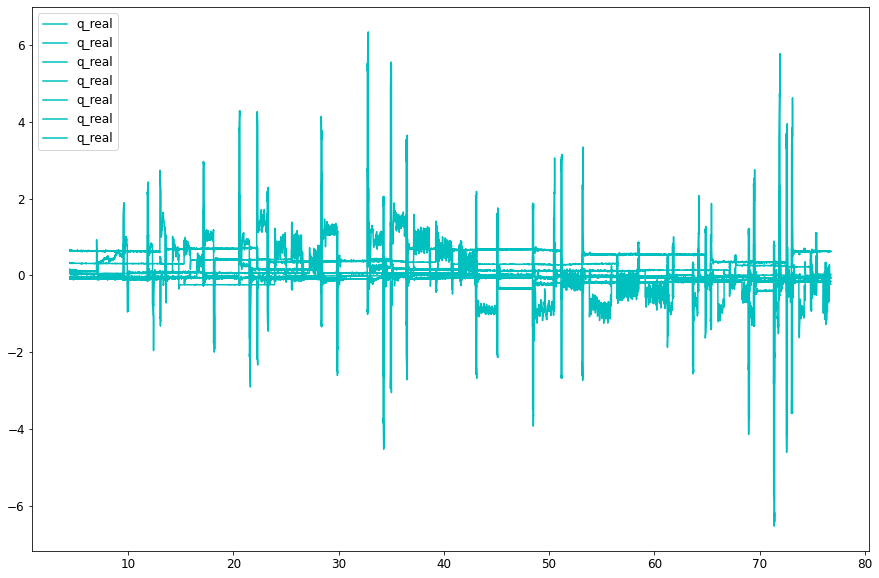

In [4]:
path = '../data/EndEffectorData/z.panda0.dat' # pick one trajectory
dataset = read_data(path)

time = dataset[:,0]
q_real = dataset[:,1:1+7]
qd_real = dataset[:, 22:22+7]
tau_cmd = dataset[:, 29:29+7]
Gra = dataset[:,43:43+7]

plt.figure(figsize=[15,10])
plt.plot(time, tau_cmd,'-c', label="q_real")
plt.legend()
plt.show()

In [5]:
import copy
bool_idx = np.isclose(qd_real, np.zeros_like(qd_real), atol=1e-7)
idx_list = []
for i, cont in enumerate(bool_idx):
    if np.all(cont) == True:
        idx_list.append(i)
        
idx_list_ = []
position = []
temp = []
for i, cont in enumerate(idx_list):
    temp.append(cont)
    if i+1 < len(idx_list) and cont+1 != idx_list[i+1]:
        position.append(copy.deepcopy(temp))
        temp.clear()
for i, cont in enumerate(position):
    if len(cont) < 10:
        position.remove(cont)

In [6]:
q1,q2,q3,q4,q5,q6,q7 = sympy.symbols("q1,q2,q3,q4,q5,q6,q7")
s = (q1,q2,q3,q4,q5,q6,q7)
J80 = sympy.lambdify(s, rbt.kin.J[7], modules='numpy')
T80 = sympy.lambdify(s, rbt.geo.T[7], modules='numpy')

## test J80

In [7]:
qd_real_0 = qd_real[6220, :]

In [8]:
J80(*qd_real_0)[:, :-1] @ np.array([qd_real_0]).reshape(7,1)

matrix([[ 8.38e-16],
        [ 4.88e-18],
        [ 3.71e-16],
        [ 4.93e-32],
        [-8.88e-16],
        [ 5.55e-17]])

In [9]:
g = np.array([ 0.0 , 0.0 , -9.81 ])

m = 0.11
r = np.array([ 0.1 , 0.1 , 0.3 ])
r_aug = np.array([ 0.1 , 0.1 , 0.3, 1])

mg = (m*g).reshape(3,)
T_80_r = T80(*q_real[0]) @ r_aug.reshape(4,1)
T_80_r = T_80_r[:-1,:].squeeze()
W = np.concatenate([mg, np.cross(T_80_r, mg).squeeze()])
W = W.reshape(6,1)

cmd_e = J80(*q_real[0])[:,:-1].T @ W
cmd_e

matrix([[ 0.  ],
        [ 1.17],
        [-0.05],
        [-1.26],
        [ 0.11],
        [-0.85],
        [ 0.05]])

In [10]:
tau_cmd[0]

array([ 0.16, -0.1 ,  0.08,  0.67,  0.05,  0.33, -0.06])

## Prepare data

In [10]:
position_points = list(map(lambda x: int(sum(x)/len(x)), position))

q_p = []
cmd_p = []
J80_p = []
T80_p = []

for point in position_points:
    q_p.append(q_real[point])
    cmd_p.append(tau_cmd[point])
    J80_p.append(J80(*q_real[point])[:,:-1])
    T80_p.append(T80(*q_real[point]))

## NLP

In [11]:
import casadi

In [12]:
r = casadi.SX.sym('r', 3)
m = casadi.SX.sym('m', 1)
x = casadi.vertcat(r,m)

In [13]:
F_res = 0
for i in range(len(q_p)):
    r_aug = casadi.vertcat(x[:3], 1)
    T_80_r = T80_p[i] @ casadi.reshape(r_aug, 4, 1)
    T_80_r = T_80_r[:-1,:]
    W = casadi.vertcat(x[3] * g, casadi.cross(T_80_r, x[3] * g))
    cmd_e = J80_p[i].T @ W
    F_res += 0.5 * casadi.sqrt((cmd_e - cmd_p[i]).T @ (cmd_e - cmd_p[i]))

In [14]:
F_res

SX(@1=0.5, @2=-9.81, @3=(@2*m), @4=-0.000637798, @5=(@2*m), @6=(((((-0.000490434*r_0)+(-1*r_1))+(@4*r_2))+-0.000227614)*@5), @7=0.476588, @8=(((((0.879126*r_0)+(-0.000735121*r_1))+(@7*r_2))+0.426735)*@5), @9=(@2*m), @10=0.0232524, @11=(@2*m), @12=(((((0.0439049*r_0)+(-0.998765*r_1))+(@10*r_2))+0.0213618)*@11), @13=0.476071, @14=(((((0.878003*r_0)+(0.0496798*r_1))+(@13*r_2))+0.426201)*@11), @15=(@2*m), @16=0.0231021, @17=(@2*m), @18=(((((0.0936424*r_0)+(-0.995338*r_1))+(@16*r_2))+0.0489014)*@17), @19=0.476131, @20=(((((0.874409*r_0)+(0.0933164*r_1))+(@19*r_2))+0.424213)*@17), @21=(@2*m), @22=0.0277515, @23=(@2*m), @24=(((((0.0923404*r_0)+(-0.995341*r_1))+(@22*r_2))+0.0491762)*@23), @25=0.519167, @26=(((((0.849566*r_0)+(0.0932916*r_1))+(@25*r_2))+0.420719)*@23), @27=(@2*m), @28=-0.0497786, @29=0.0757076, @30=(@2*m), @31=(((((0.0704644*r_0)+(-0.994637*r_1))+(@29*r_2))+0.0523829)*@30), @32=0.99876, @33=0.51453, @34=(((((0.85168*r_0)+(0.0995006*r_1))+(@33*r_2))+0.4204)*@30), @35=(@2*m), @36

In [15]:
x0 = [0.2,0.2,0.2,0.2]

In [16]:
nlp = {'x':x, 'f':F_res}
S = casadi.nlpsol('S', 'ipopt', nlp)
res = S(x0=x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [17]:
x_opt = res['x']

In [18]:
print('The calibration results: ', x_opt)

The calibration results:  [-0.152441, 0.138538, 0.0512808, -0.0446229]


## Test

In [19]:
r = [-0.152441, 0.138538, 0.0512808]
mg = -0.0446229 * g
e_res = []
for i in range(len(q_p)):
    r_aug = np.array(r + [1])

    T_80_r = T80_p[i] @ r_aug.reshape(4,1)
    T_80_r = T_80_r[:-1,:]
    cross = np.cross(T_80_r.squeeze(), mg)
    W = np.concatenate([mg, cross.squeeze()])

    cmd_e = J80_p[i].T @ W
    e_res.append(cmd_e.squeeze())

In [21]:
matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

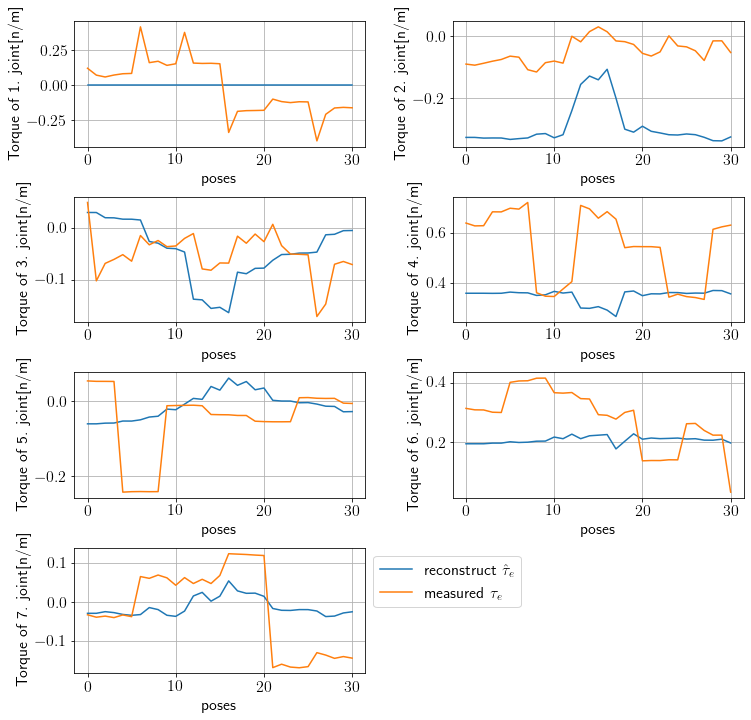

In [28]:
e_res = np.array(e_res).squeeze()
cmd_p = np.array(cmd_p).squeeze()

plt.figure(figsize=[12,12])
for channel in range(7):
    
    plt.subplot(4,2,channel+1,xlabel="poses", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.plot(e_res[:,channel], label=r'reconstruct $\hat{\tau}_{e}$')
    plt.plot(cmd_p[:,channel], label=r'measured $\tau_{e}$')
    plt.grid()
plt.legend()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig('/home/jiayun/Desktop/cali.jpg', dpi=200)
plt.show()